# Transfer Learning

https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb

<설치></br>
conda install keras

In [1]:
# __future__ :파이썬 2 버전과 파이썬 3 버전의 호환을 위하여 사용되는 모듈
from __future__ import absolute_import, division, print_function 

# OS: 운영체제와 관련된 명령을 수행할 수 있다.
import os
# opencv2 의 모듈을 사용할 수 있다.
import cv2

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np

# pyplot: 그래프를 그리기위해 지원되는 모듈 
import matplotlib.pyplot as plt

# image: matplotlib에서 이미지를 활용하고자 할 때 사용하는 모듈
import matplotlib.image as mpimg


/home/pirl/anaconda3/envs/edu1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pirl/anaconda3/envs/edu1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pirl/anaconda3/envs/edu1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pirl/anaconda3/envs/edu1/lib/python3.6/site-packages

TensorFlow version is  1.12.0


### Data preprocessing

In [2]:
# 데이터 가져오기, extract = True 일 시 압축 파일을 풀라는 명령 
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip", 
                                   fname="cats_and_dogs_filtered.zip", extract=True)

#zip_file="./경로/cats_and_dogs_filtered.zip"                                

# 확장자를 기준으로 파일 이름 나누기 
base_dir, _ = os.path.splitext(zip_file)

### Prepare training and validation cats and dogs datasets

In [3]:
# train폴더와 validation폴더 경로명 생성 및 저장
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# train cats 이미지가 들어있는 경로명 생성 및 저장
train_cats_dir = os.path.join(train_dir, 'cats')
print ('Total training cat images:', len(os.listdir(train_cats_dir)))

# train dog 이미지가 들어있는 경로명 생성 및 저장
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

# validaton cats 이미지가 들어있는 경로명 생성 및 저장
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

# validaton dog 이미지가 들어있는 경로명 생성 및 저장
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


### Create Image Data Generator with Image Augmentation

- ImageDataGenerator() 참고: https://keraskorea.github.io/posts/2018-10-24-little_data_powerful_model/

In [4]:
image_size = 224 # All images will be resized to 224 x 224
batch_size = 32

# Rescale
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# 디렉토리에서 바로 레이블과 이미지 가져오기 
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),  
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

# 클래스 인덱스 정보 보기 
print(train_generator.class_indices)
print(validation_generator.class_indices)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}


- class_mode : 분류 방식에 대해서 지정합니다. 다중 클래스일 경우 "categorical"로 지정해주세요
  

### Create the base model from the pre-trained convnets

- tensorflow.keras.applications 모듈을 사용하여 pretrained된 모델을 사용할 수 있다.
- Xception, VGG16, VGG19, ResNet, InseptionV3, InseptionResNetV2, MobileNet, DenseNet, NASNet 사용가능 

- 참고사이트: https://keras.io/applications/

In [5]:
IMG_SHAPE = (image_size, image_size, 3)

#Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

## Feature extraction

### Freeze the convolutional base  

In [6]:
#분류모델을 제외하고 가져온 모델부분을  Freeze 시켜 학습시에도 가중치가 변하지 않도록 함
base_model.trainable = False

In [7]:
# Let's take a look at the base model architecture
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

##### Add a classification head

In [8]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])

- 다중 분류의 경우 activation = "softmax"

### Compile the model

In [9]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

- loss의 경우 다중 클래스 분류일 때 "categorical_crossentropy"를 설정해주면 된다.

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


## Train

- "could not import PIL.Image" 오류발생시
- 참고: https://stackoverflow.com/questions/48225729/importerrorcould-not-import-pil-image-working-with-keras-ternsorflow/50775336

- pip install Pillow 를 통해 해당 가상환경에 Pillow를 설치해주면 되겠다.

In [11]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 22s 351ms/step - loss: 0.7231 - acc: 0.5000 - val_loss: 0.7091 - val_acc: 0.4980
Epoch 2/10
62/62 [==============================] - 16s 258ms/step - loss: 0.7005 - acc: 0.4990 - val_loss: 0.6959 - val_acc: 0.4829
Epoch 3/10
62/62 [==============================] - 15s 244ms/step - loss: 0.6894 - acc: 0.5383 - val_loss: 0.6872 - val_acc: 0.5282
Epoch 4/10
62/62 [==============================] - 16s 253ms/step - loss: 0.6811 - acc: 0.5812 - val_loss: 0.6795 - val_acc: 0.5625
Epoch 5/10
62/62 [==============================] - 16s 265ms/step - loss: 0.6739 - acc: 0.6255 - val_loss: 0.6723 - val_acc: 0.6230
Epoch 6/10
62/62 [==============================] - 16s 256ms/step - loss: 0.6670 - acc: 0.6487 - val_loss: 0.6648 - val_acc: 0.6482
Epoch 7/10
62/62 [==============================] - 17s 274ms/step - loss: 0.6604 - acc: 0.6840 - val_loss: 0.6578 - val_acc: 0.6895
Epoch 8/10
62/62 [==============================] - 14s 231ms/step - 

### Learning curves

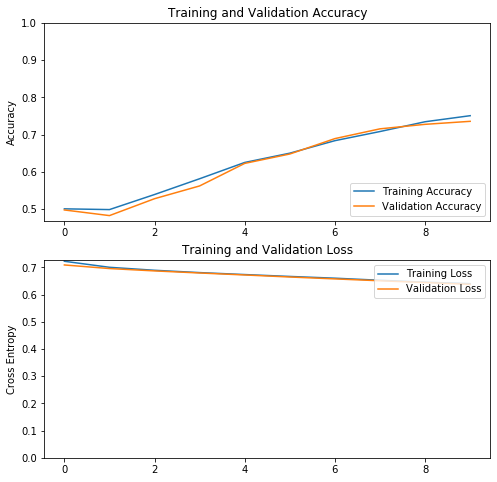

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

### Fine tuning

In [13]:
base_model.trainable = True

In [14]:
# base model의 layer 갯수를 확인
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [15]:
# Fine tuning을 시킬 기준 layer 선정
fine_tune_at = 15

# Fine tuning을 시킬 기준 layer 이전의 layer들을 모두 freezing
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

### Compile the model

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 7,079,937
Non-trainable params: 7,635,264
_________________________________________________________________


In [18]:
len(model.trainable_variables)

8

In [19]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [20]:
model.trainable_variables

[<tf.Variable 'block5_conv1/kernel:0' shape=(3, 3, 512, 512) dtype=float32>,
 <tf.Variable 'block5_conv1/bias:0' shape=(512,) dtype=float32>,
 <tf.Variable 'block5_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32>,
 <tf.Variable 'block5_conv2/bias:0' shape=(512,) dtype=float32>,
 <tf.Variable 'block5_conv3/kernel:0' shape=(3, 3, 512, 512) dtype=float32>,
 <tf.Variable 'block5_conv3/bias:0' shape=(512,) dtype=float32>,
 <tf.Variable 'dense/kernel:0' shape=(512, 1) dtype=float32>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32>]

### Continue Train the model

In [21]:
history_fine = model.fit_generator(train_generator, 
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs, 
                                   workers=4,
                                   validation_data=validation_generator, 
                                   validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 17s 274ms/step - loss: 0.4140 - acc: 0.8347 - val_loss: 0.2745 - val_acc: 0.8972
Epoch 2/10
62/62 [==============================] - 15s 248ms/step - loss: 0.2531 - acc: 0.9073 - val_loss: 0.2083 - val_acc: 0.9123
Epoch 3/10
62/62 [==============================] - 16s 251ms/step - loss: 0.1869 - acc: 0.9330 - val_loss: 0.2512 - val_acc: 0.8881
Epoch 4/10
62/62 [==============================] - 16s 252ms/step - loss: 0.1582 - acc: 0.9481 - val_loss: 0.2032 - val_acc: 0.9254
Epoch 5/10
62/62 [==============================] - 15s 244ms/step - loss: 0.1381 - acc: 0.9506 - val_loss: 0.2820 - val_acc: 0.8800
Epoch 6/10
62/62 [==============================] - 16s 263ms/step - loss: 0.1248 - acc: 0.9577 - val_loss: 0.1430 - val_acc: 0.9496
Epoch 7/10
62/62 [==============================] - 16s 260ms/step - loss: 0.0906 - acc: 0.9698 - val_loss: 0.1368 - val_acc: 0.9395
Epoch 8/10
62/62 [==============================] - 16s 259ms/step - 

### Learning curves 

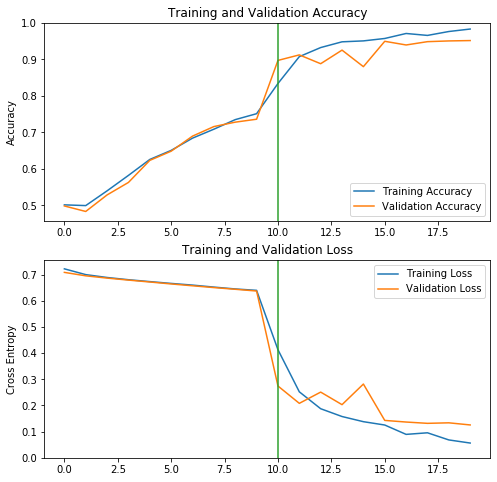

In [22]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([epochs,epochs], plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.plot([epochs,epochs], plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Loss')
plt.show()